<a href="https://colab.research.google.com/github/AbeerProg/RRDS/blob/main/Embedding%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow keras

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd

df = pd.read_excel('Final_dataset.xlsx')

# Preprocess text (tokenizing)
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

#Tokenization and label

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['review_text'])
sequences = tokenizer.texts_to_sequences(df['review_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
numerical_columns = df.iloc[:, 1:11]
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_columns)
labels = df.iloc[:, -1]



# Train-test split
X_text_train, X_text_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    padded_sequences, scaled_numerical_features, labels, test_size=0.2, random_state=42
)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(np.hstack([X_text_train, X_other_train]), y_train)

# Split resampled data back into text and other features
X_text_train_resampled = X_train_resampled[:, :X_text_train.shape[1]]
X_other_train_resampled = X_train_resampled[:, X_text_train.shape[1]:]

# Define the input layers
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
other_input = Input(shape=(X_other_train.shape[1],), name='other_input')

# Text branch (Embedding + LSTM)
embedding = Embedding(MAX_VOCAB_SIZE, 128)(text_input)
lstm = LSTM(64)(embedding)

# Combine LSTM output and numerical input
combined = concatenate([lstm, other_input])

# Dense layers
x = Dense(64, activation='relu')(combined)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(32, activation='relu')(x)

# Output layer (binary classification)
output = Dense(1, activation='sigmoid')(x)

# model Creation
model = Model(inputs=[text_input, other_input], outputs=output)

# model Compiling
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# model training
history = model.fit(
    [X_text_train_resampled, X_other_train_resampled],
    y_train_resampled,
    epochs=10,
    batch_size=64,
    validation_data=([X_text_test, X_other_test], y_test)
)


Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7669 - loss: 0.4821 - val_accuracy: 0.8696 - val_loss: 0.3009
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8736 - loss: 0.2988 - val_accuracy: 0.8694 - val_loss: 0.2996
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9136 - loss: 0.2203 - val_accuracy: 0.8601 - val_loss: 0.3409
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9425 - loss: 0.1556 - val_accuracy: 0.8561 - val_loss: 0.4211
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9605 - loss: 0.1096 - val_accuracy: 0.8485 - val_loss: 0.5392
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9660 - loss: 0.0907 - val_accuracy: 0.8487 - val_loss: 0.5962
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9742 - loss: 0.0699 - val_accuracy: 0.8405 - val_loss: 0.6670
Epoch 8/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9797 - loss: 0.0586 - val_accuracy: 0.

In [ ]:
# Evaluation
loss, accuracy = model.evaluate([X_text_test, X_other_test], y_test)
print(f"Test Accuracy: {accuracy}")

# F1-Score, Precision, Recall
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = (model.predict([X_text_test, X_other_test]) > 0.5).astype("int32")
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"F1-Score: {f1}, Precision: {precision}, Recall: {recall}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8447 - loss: 0.8973
Test Accuracy: 0.8412476778030396
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
F1-Score: 0.8098159509202454, Precision: 0.815272318921954, Recall: 0.804432132963989


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import numpy as np

# Predict the labels for the test set
y_pred_probs = model.predict([X_text_test, X_other_test])  # Predict probabilities
y_pred = (y_pred_probs > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC: {roc_auc:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8412
Confusion Matrix:
[[2162  329]
 [ 353 1452]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2491
           1       0.82      0.80      0.81      1805

    accuracy                           0.84      4296
   macro avg       0.84      0.84      0.84      4296
weighted avg       0.84      0.84      0.84      4296

AUC-ROC: 0.9070


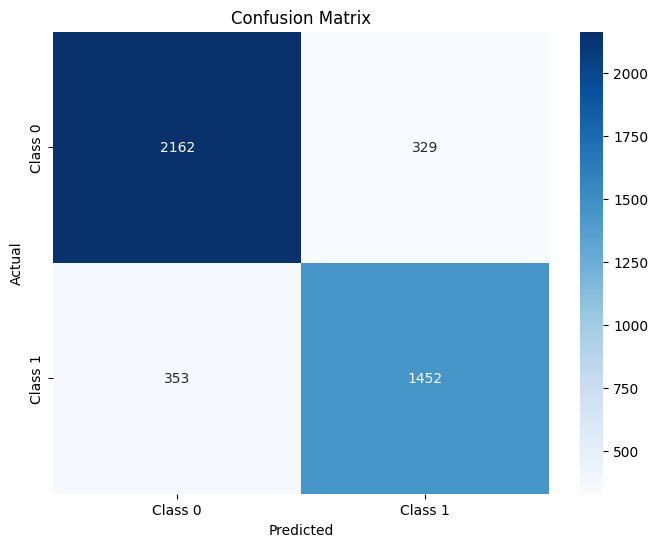

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
